In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Given a set of size N, returns a random partition of this set
# containing two subsets of size N - k and k
def random_bipartite_data (data_set, k):
    np.random.shuffle (data_set)
    return (data_set[k:], data_set[:k])


# Plots E_in and E_val
def plot_error (n, errors_list, labels_list):
    ax = plt.gca ()
    x = range (1, n + 1)
    for i, error_t in enumerate (errors_list):
        plt.plot (x, error_t, label = labels_list[i])    
    handlers, labels = ax.get_legend_handles_labels ()
    ax.legend (handlers, labels, loc = 'upper right', numpoints = 1)
    plt.ylabel ('Relative error')
    plt.xlabel ('Number of images sampled x500')
    plt.show ()
    plt.clf ()

# MAC0460/5832 - Lista 4: SVM - MNIST

### Data de Entrega: 23h55m do dia 11/07/2017

##### Classificação de dígitos
Os dataset para esta tarefa é uma adaptação do disponível na competição do kaggle de reconhecimento de dígitos (https://www.kaggle.com/c/digit-recognizer) e está disponível em http://vision.ime.usp.br/~caiomr/mac0460_5832/train_svm.csv.gz. O dataset está sob a licença Creative Commons Attribution-Share Alike 3.0 license (https://creativecommons.org/licenses/by-sa/3.0/). O dataset foi zipado, e apenas os dígitos 5 e 6 foram mantidos. Cada linha (amostra) do arquivo contém 257 colunas: a primeira informa o label da amostra (0 para o dígito 5, 1 para o dígito 6) e as outras 256 são os valores dos pixels da imagem (16 x 16) que representa o dígito.

Note que esse dataset difere do usado no EP3: as imagens sofreram pequenas rotações e translações aleatórias, além de terem sido escalonadas para o tamanho 16x16. Veja também que pode ser necessário realizar algum tipo de normalização para realizar um treinamento efetivo com SVM. Para auxiliar na normalização dos dados, consultem o seguinte link: http://scikit-learn.org/stable/modules/preprocessing.html. 

Q1. Use SVM para classificar os dígitos 5 e 6. Utilize as funções do scikit learn (http://scikit-learn.org/, http://scikit-learn.org/stable/modules/svm.html) para realizar o treinamento.

Teste os kernels linear e RBF da seguinte maneira:
1. Escolha aleatoriamente 932 amostras para formarem o conjunto de teste.
2. Com as 7000 amostras restantes, utilize validação cruzada (com número de folds K = 5) para escolher os parâmetros do seu classificador, isto é: C (peso da *soft margin*) para o kernel linear; C e gamma para o kernel RBF.
3. Plote a curva experimental de aprendizado para o melhor SVM com kernel linear e o melhor SVM com kernel RBF escolhidos por validação cruzada. Use as 932 amostras do conjunto de teste para estimar $E_{out}$. Comente sobre o resultado.

In [2]:
data = np.genfromtxt('data/train_svm.csv', delimiter=',')
print (data.shape)
# First we scale data to have zero mean and unit variance
data[:, 1:] = scale (data[:, 1:])

# Bipartites into test data and validation data
[validation_data, test_data] = random_bipartite_data (data, 932)
print (test_data.shape)
print (validation_data.shape)

(7932, 257)
(932, 257)
(7000, 257)


In [7]:
linear_parameters = {'kernel': ['linear'], 'C': [1, 10, 100]}
rbf_parameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 
                  'C':[1, 10, 100]}

clf_linear = GridSearchCV (SVC (C=1), linear_parameters, cv=5)
clf_linear.fit (validation_data[:, 1:], validation_data[:, 0])

clf_rbf = GridSearchCV (SVC (C=1), rbf_parameters, cv=5)
clf_rbf.fit (validation_data[:, 1:], validation_data[:, 0])

print(clf_linear.best_params_)
print(clf_rbf.best_params_)

{'C': 10, 'kernel': 'linear'}
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Erro para o melhor classificador com kernel linear:


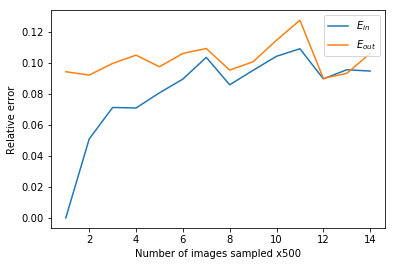

E_out = 0.106223175966
Erro para o melhor classificador com kernel RBF:


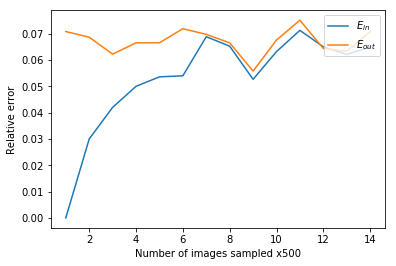

E_out = 0.0708154506438


In [30]:
linear_svm = SVC (C=10, kernel='linear')

e_in_arr = []
e_out_arr = []
e_out = 0

for i in range (0, validation_data.shape[0], 500):
    linear_svm.fit (validation_data[i:i + 500, 1:], 
                    validation_data[i:i + 500, 0])
    e_in = 1 - linear_svm.score (validation_data[:i + 500, 1:], 
                             validation_data[:i + 500, 0])
    e_out = 1 - linear_svm.score (test_data[:, 1:],
                              test_data[:, 0])
    e_in_arr.append (e_in)
    e_out_arr.append (e_out)
        
labels_list = ['$E_{in}$', '$E_{out}$']        
erros_list = [e_in_arr, e_out_arr]
print ("Erro para o melhor classificador com kernel linear:")
plot_error (len (e_in_arr), erros_list, labels_list)
print ("E_out = " + str (e_out))


rbf_svm = SVC (C=100, kernel='rbf', gamma=0.001)

e_in_arr = []
e_out_arr = []
e_out = 0

for i in range (0, validation_data.shape[0], 500):
    rbf_svm.fit (validation_data[i:i + 500, 1:], 
                    validation_data[i:i + 500, 0])
    e_in = 1 - rbf_svm.score (validation_data[:i + 500, 1:], 
                             validation_data[:i + 500, 0])
    e_out = 1 - rbf_svm.score (test_data[:, 1:],
                              test_data[:, 0])
    e_in_arr.append (e_in)
    e_out_arr.append (e_out)
        
labels_list = ['$E_{in}$', '$E_{out}$']        
erros_list = [e_in_arr, e_out_arr]
print ("Erro para o melhor classificador com kernel RBF:")
plot_error (len (e_in_arr), erros_list, labels_list)
print ("E_out = " + str (e_out))

Primeiro, podemos observar que as curvas de $E_{in}$ e $E_{out}$ são próximas no fim do aprendizado, o que indica que os classificadores generalizam bem o conjunto de dados. Além disso, verificamos que ambos os classificadores tem bom desempenho, com $E_{out}$ de 10% e 7% para os classificadores de kernel linear e RBF respectivamente.